<a href="https://colab.research.google.com/github/michelleaeh/Dissertation/blob/master/2MyoASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


**The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.**

**Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.**

**The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL**

**If you use this dataset please cite the following papers:**

**@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}**

**@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}**

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import scipy as sp
import warnings

from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

# Import zip containing all files
file_name = "/content/2MyoASL.zip"

# Extract all files from zip
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [2]:
# Generate matrices for all combinations of sensors (E=3, A=5, G=7, O=11)
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155]
comb=['e', 'a', 'g', 'o', 'ea', 'eg', 'eo', 'ag', 'ao', 'go', 'eag', 'eao', 'ego', 'ago', 'eago']
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
    'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']

# Initialization of counters
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']
lengths=np.zeros(849, dtype=int)
reps=np.zeros(36,dtype=int)
features=np.zeros(15)
target=np.zeros(15)

fn=np.arange(35)
wordnum=-1
counter=0
n=0

In [3]:
# Combine all files
for w in words:
  repcount=0
  wordnum+=1

  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'

    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      lengths[counter-1]=len(trial)
      
      # Replace counter with evaluated term
      for r in range(0,len(trial)):
        trial.iloc[r,0]=wordnum
      #trial.set_index('Counter', append=True).swaplevel(0,1)
      #trial.iloc[0,0]=wordnum
      #trial=trial.set_index('Counter', append=True).swaplevel(0,1)
      #print(trial)
      
      # Combine all trials
      if path=='/content/2MyoASL/allmorning_10.csv':
          matrix=trial
      else:
          #matrix=pd.concat([matrix, trial],keys=[wordnum])
          matrix=pd.concat([matrix,trial])
"""
      # Plot
      if i==10:
        # Create plot for EMG
        emgp, axs=plt.subplots(16,figsize=(30,30))
        for z in emg:
          emgp.suptitle('EMG for ' + w)
          axs[emg.index(z)].plot(trial.loc[:, z].values)
        
        # Create plot for accelerometer
        plt.figure()
        alx=plt.axes(projection='3d')
        alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
        alx.set_title('Accelerometer on left arm for '+w)

        plt.figure()
        arx=plt.axes(projection='3d')
        arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
        arx.set_title('Accelerometer on right arm for '+w)

        # Create plot for gyroscope
        plt.figure()
        glx=plt.axes(projection='3d')
        glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
        glx.set_title('Gyroscope on left arm for '+w)

        plt.figure()
        grx=plt.axes(projection='3d')
        grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
        grx.set_title('Gyroscope on right arm for '+w)

        # Create plot for orientation
        orip, axt=plt.subplots(6,figsize=(30,30))
        for f in ori:
          orip.suptitle('Orientation for ' + w)
          axt[ori.index(f)].plot(trial.loc[:, f].values)

      else:
        # Plot EMG
        for z in emg:
          axs[emg.index(z)].plot(trial.loc[:, z].values)
        
        # Plot accelerometer
        alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
        arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
        
        # Plot gyroscope
        glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
        grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          
        # Plot orientation
        for f in ori:
          axt[ori.index(f)].plot(trial.loc[:, f].values)
        
        warnings.filterwarnings("ignore", category=RuntimeWarning) 
  reps[wordnum]=repcount
warnings.filterwarnings("ignore", category=RuntimeWarning)
"""

'\n      # Plot\n      if i==10:\n        # Create plot for EMG\n        emgp, axs=plt.subplots(16,figsize=(30,30))\n        for z in emg:\n          emgp.suptitle(\'EMG for \' + w)\n          axs[emg.index(z)].plot(trial.loc[:, z].values)\n        \n        # Create plot for accelerometer\n        plt.figure()\n        alx=plt.axes(projection=\'3d\')\n        alx.plot3D(trial.loc[:, \'AXL\'].values, trial.loc[:, \'AYL\'].values, trial.loc[:, \'AZL\'].values)\n        alx.set_title(\'Accelerometer on left arm for \'+w)\n\n        plt.figure()\n        arx=plt.axes(projection=\'3d\')\n        arx.plot3D(trial.loc[:, \'AXR\'].values, trial.loc[:, \'AYR\'].values, trial.loc[:, \'AZR\'].values)\n        arx.set_title(\'Accelerometer on right arm for \'+w)\n\n        # Create plot for gyroscope\n        plt.figure()\n        glx=plt.axes(projection=\'3d\')\n        glx.plot3D(trial.loc[:, \'GXL\'].values, trial.loc[:, \'GYL\'].values, trial.loc[:, \'GZL\'].values)\n        glx.set_title(\'G

In [4]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  m=matrix
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  products[n]=m
  exec(comb[n]+"=products[n]")
  n+=1
  
  # Normalize and Standardize each of the 15 matrices
  # Separate features from target values
  x = m.loc[:, m.columns != 'Counter'].values   # Features
  y = m.loc[:,['Counter']].values               # Target

  ## Normalize features so that each column is between 0 and 1
  norm_matrix=(m-m.min())/(m.max()-m.min())
  exec("norm_matrix_"+comb[n-1]+"=pd.DataFrame(norm_matrix)")

  # Normalize features
  normalized_matrix=(x-x.min())/(x.max()-x.min())
  exec("normalized_matrix_"+comb[n-1]+"=pd.DataFrame(normalized_matrix)")

  # Standardize features with mean=0 and deviation=1
  standardized_matrix=StandardScaler().fit_transform(x)
  exec("standardized_matrix_"+comb[n-1]+"=pd.DataFrame(standardized_matrix)")

  # Save data frames as csv files
  #matrix.to_csv(path_or_buf='/content/matrix_'+comb[n-1]+'.csv')
  exec("norm_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/normmatrix_'+comb[n-1]+'.csv')")
  exec("normalized_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/normalizedmatrix_'+comb[n-1]+'.csv')")
  exec("standardized_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/standardizedmatrix_'+comb[n-1]+'.csv')")

In [5]:
# Butterworth
high = 20/(1000/2)
low = 450/(1000/2)
b, a = sp.signal.butter(4, [high,low], btype='bandpass')

for r in emg:
  norm_matrix_eago[[r]]
  # process EMG signal: filter EMG
  emg_filtered = sp.signal.lfilter(b, a, norm_matrix_eago[[r]])
  norm_matrix_eago[[r]]=emg_filtered

Normalized matrix
[0.25083189 0.20435405 0.15654047 0.11008617 0.09077665 0.0390604
 0.02905111 0.02436654 0.01217295 0.0103573  0.00812394 0.0078553
 0.00719733 0.00499011 0.0043624  0.00431081 0.00423006 0.00380632
 0.00321878 0.00297968 0.00268159 0.00259915 0.00205035 0.00192917
 0.00179032 0.00164651 0.00161939 0.00128209 0.00106286 0.00104237
 0.00099056 0.00078071 0.00077025 0.00063044 0.00045197]
[59.9714823  54.13087373 47.37690951 39.73011169 36.07783713 23.66583035
 20.40961496 18.69176718 13.21147683 12.18643659 10.79286653 10.612916
 10.15872498  8.45879663  7.9089013   7.86199408  7.78800956  7.38764555
  6.7935868   6.53639731  6.20083081  6.10477251  5.42209531  5.25943172
  5.06663144  4.85887392  4.8186959   4.28758152  3.9038325   3.86602622
  3.7687139   3.34577899  3.32329696  3.0065987   2.54570401]


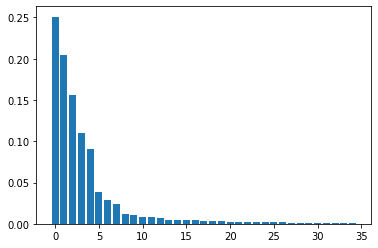

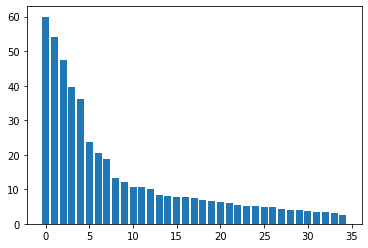

           PC 1      PC 2      PC 3  ...     PC 34      PC35  Counter
0     -0.067972 -0.037443  0.347942  ... -0.000608 -0.000665        0
1     -0.065030 -0.036675  0.347902  ... -0.000246 -0.000631        0
2     -0.066087 -0.090420  0.353337  ...  0.005860  0.001148        0
3     -0.060039 -0.040451  0.359010  ... -0.000754 -0.013879        0
4     -0.030303  0.039197  0.343791  ...  0.039721 -0.005539        0
...         ...       ...       ...  ...       ...       ...      ...
42649  0.439732 -0.367639  0.077823  ...  0.000525  0.003151       35
42650  0.437026 -0.406955  0.086990  ...  0.000559 -0.001696       35
42651  0.423911 -0.391804  0.113567  ...  0.002809 -0.000751       35
42652  0.425978 -0.409322  0.110343  ...  0.002177  0.000900       35
42653 -0.521546 -0.355828 -0.154055  ... -0.001353 -0.000797       35

[42654 rows x 35 columns]


'\n# PCA for normalizedmatrix\npca = PCA(n_components=34)\npca.fit(normalized_matrix)\nprint("Normalized features")\nprint(pca.explained_variance_ratio_)\nprint(pca.singular_values_)\nplt.figure()\nplt.bar(fn[0:34],pca.explained_variance_ratio_)\nplt.show()\nplt.bar(fn[0:34],pca.singular_values_)\nplt.show()\n\n# PCA for standardizedmatrix\npca = PCA(n_components=34)\npca.fit(standardized_matrix)\nprint("Standardized features")\nprint(pca.explained_variance_ratio_)\nprint(pca.singular_values_)\nplt.figure()\nplt.bar(fn[0:34],pca.explained_variance_ratio_)\nplt.show()\nplt.bar(fn[0:34],pca.singular_values_)\nplt.show()\n'

In [6]:
# PCA for normmatrix
pca = PCA(n_components=35)
comp=pca.fit_transform(norm_matrix_eago)
principal=pd.DataFrame(data=comp, columns=['PC 0', 'PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8', 'PC 9', 'PC 10', 
                                           'PC 11', 'PC 12', 'PC 13', 'PC 14', 'PC 16', 'PC 17', 'PC 18', 'PC 19', 'PC 20', 
                                           'PC 21', 'PC 22', 'PC 23', 'PC 24', 'PC 25', 'PC 26', 'PC 27', 'PC 28', 'PC 29', 
                                           'PC 30', 'PC 31', 'PC 32', 'PC 33', 'PC 34', 'PC35'])
#principal.reset_index(drop=True, inplace=True)
#norm_matrix_eago[['Counter']].reset_index(drop=True, inplace=True)
norm_matrix_eago.reset_index(drop=True, inplace=True)
m.reset_index(drop=True, inplace=True)
#finaldf=pd.join([principal, norm_matrix_eago[['Counter']]], axis=1, ignore_index=True).reset_index()
finaldf=principal.join(m[['Counter']],how='outer')
finaldf=finaldf.drop(columns=['PC 0'])
####finaldf=principal
####print(m['Counter'])
####finaldf['Word']=m['Counter']
#finaldf=pd.concat([principal,norm_matrix_eago[['Counter']]], axis=1, ignore_index=True)

print("Normalized matrix")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn,pca.explained_variance_ratio_)
plt.show()
plt.bar(fn,pca.singular_values_)
plt.show()
print(finaldf)
#print(principal.join(norm_matrix_eago[['Counter']],how='inner'))

"""
# PCA for normalizedmatrix
pca = PCA(n_components=34)
pca.fit(normalized_matrix)
print("Normalized features")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[0:34],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[0:34],pca.singular_values_)
plt.show()

# PCA for standardizedmatrix
pca = PCA(n_components=34)
pca.fit(standardized_matrix)
print("Standardized features")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[0:34],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[0:34],pca.singular_values_)
plt.show()
"""

In [7]:
# SVM
x = finaldf.loc[:, finaldf.columns != 'Counter'].values   # Features
y = finaldf.loc[:,['Counter']].values               # Target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.6, random_state=0)

pca = PCA(n_components=30)
pca.fit(x_train)
x_t_train = pca.transform(x_train)
x_t_test = pca.transform(x_test)
clf = SVC()
clf.fit(x_t_train, y_train)
print ('score', clf.score(x_t_test, y_test))
print ('pred label', clf.predict(x_t_test))
print('length',len(clf.predict(x_t_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


score 0.7094908764115188
pred label [ 7 34  9 ...  3 35  3]
length 25593


TODO:

-check what happens when combining diff data sources

-graph components

find correlations

interpret pca results

-try pca per individual/word

-read dataset papers

correlation component with word

try stright to svm

resend email

check what is the data

merge timeseries word index

see how stable each feature are

standard deviation timeseries

try without filter

multi-class classifier SVM



https://www.researchgate.net/publication/303707429_Combining_Smartphone_and_Smartwatch_Sensor_Data_in_Activity_Recognition_Approaches_an_Experimental_Evaluation

References

https://stackoverflow.com/questions/56449262/how-to-upload-folders-to-google-colab

https://github.com/datarail/datarail/issues/39

https://dbader.org/blog/python-check-if-file-exists

https://datacarpentry.org/python-socialsci/11-joins/index.html

https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html

https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html

https://stackoverflow.com/questions/32194967/how-to-do-pca-and-svm-for-classification-in-python

https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator

https://scikit-learn.org/stable/modules/cross_validation.html

https://stackoverflow.com/questions/47684606/merge-cells-with-pandas

https://scientificallysound.org/2016/08/18/python-analysing-emg-signals-part-3/

https://stackoverflow.com/questions/58374492/python-valueerror-the-length-of-the-input-vector-x-must-be-greater-than-padle


In [8]:
"""
### Combine all files
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']
lengths=np.zeros(849, dtype=int)
reps=np.zeros(36,dtype=int)
wordnum=-1
counter=0

for w in words:
  repcount=0
  wordnum+=1

  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'

    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      lengths[counter-1]=len(trial)
      
      # Replace counter with evaluated term
      for r in range(0,len(trial)):
        trial.iloc[r,0]=wordnum
        
      # Combine all trials
      if path=='/content/2MyoASL/allmorning_10.csv':
          matrix=trial
          
          # Create plot for EMG

          # Create plot for accelerometer
          plt.figure()
          alx=plt.axes(projection='3d')
          alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
          alx.set_title('Accelerometer on left arm')

          plt.figure()
          arx=plt.axes(projection='3d')
          arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
          arx.set_title('Accelerometer on right arm')

          # Create plot for gyroscope
          plt.figure()
          glx=plt.axes(projection='3d')
          glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
          glx.set_title('Gyroscope on left arm')

          plt.figure()
          grx=plt.axes(projection='3d')
          grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          grx.set_title('Gyroscope on right arm')
      else:
          matrix=pd.concat([matrix, trial])

          ###############################################
          # Create plot for accelerometer
          alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
          arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
          #plt.show()

          # Create plot for gyroscope
          glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
          grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          ###############################################

  reps[wordnum]=repcount
plt.show()
""" 

"\n### Combine all files\nwords=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']\nlengths=np.zeros(849, dtype=int)\nreps=np.zeros(36,dtype=int)\nwordnum=-1\ncounter=0\n\nfor w in words:\n  repcount=0\n  wordnum+=1\n\n  for i in range (10, 120):\n    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'\n\n    if os.path.exists(path)==True:\n      counter+=1\n      repcount+=1\n      trial=pd.read_csv(path)\n      lengths[counter-1]=len(trial)\n      \n      # Replace counter with evaluated term\n      for r in range(0,len(trial)):\n        trial.iloc[r,0]=wordnum\n        \n      # Combine all trials\n      if path=='/content/2MyoASL